In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from tempfile import NamedTemporaryFile

from recommenders.datasets import movielens
from recommenders.models.ncf.dataset import Dataset as NCFDataset
from recommenders.models.ncf.ncf_singlenode import NCF
from recommenders.evaluation.python_evaluation import rmse, mae
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error  # <-- để tính MSE


In [3]:
# 1) Load data
data = movielens.load_pandas_df(
    size="100k",
    header=["userID", "itemID", "rating", "timestamp"]
)[["userID", "itemID", "rating"]]

n_runs = 10
rmse_list, mae_list, mse_list = [], [], []
train_time_list, test_time_list = [], []

INFO:recommenders.datasets.download_utils:Downloading https://files.grouplens.org/datasets/movielens/ml-100k.zip
100%|██████████| 4.81k/4.81k [00:16<00:00, 296KB/s]


In [6]:
for i in range(n_runs):
    # 2) Split
    train, test = train_test_split(data, test_size=0.2, random_state=42 + i)
    train = train.sort_values(by="userID")

    # 3) Ghi file tạm cho NCFDataset
    with NamedTemporaryFile("w", suffix=".csv", delete=False) as f:
        train.to_csv(f.name, index=False)
        train_path = f.name

    # 4) Build & train model + đo thời gian TRAIN
    ncf_data = NCFDataset(train_path, seed=42 + i)
    ncf_model = NCF(
        n_users=ncf_data.n_users,
        n_items=ncf_data.n_items,
        model_type="NeuMF",
        batch_size=256,
        learning_rate=0.001,
        n_epochs=10,
        seed=42 + i
    )
    st = time.time()
    ncf_model.fit(ncf_data)
    train_time = time.time() - st
    train_time_list.append(train_time)

    # 5) Predict + đo thời gian TEST (suy luận)
    valid_users = set(train["userID"].unique())
    valid_items = set(train["itemID"].unique())
    mask = test["userID"].isin(valid_users) & test["itemID"].isin(valid_items)
    test_filtered = test[mask].copy()

    st = time.time()
    preds = [
        ncf_model.predict(u, it)
        for u, it in zip(test_filtered["userID"], test_filtered["itemID"])
    ]
    test_time = time.time() - st
    test_time_list.append(test_time)

    test_filtered["prediction"] = preds

    # 6) Metrics
    rmse_score = rmse(
        rating_true=test_filtered,
        rating_pred=test_filtered,
        col_user="userID",
        col_item="itemID",
        col_rating="rating",
        col_prediction="prediction",
    )
    mae_score = mae(
        rating_true=test_filtered,
        rating_pred=test_filtered,
        col_user="userID",
        col_item="itemID",
        col_rating="rating",
        col_prediction="prediction",
    )
    mse_score = mean_squared_error(test_filtered["rating"], test_filtered["prediction"])

    rmse_list.append(rmse_score)
    mae_list.append(mae_score)
    mse_list.append(mse_score)

    print(
        f"Lần {i+1}: "
        f"Train {train_time:.3f}s | Test {test_time:.3f}s | "
        f"RMSE = {rmse_score:.4f} | MAE = {mae_score:.4f} | MSE = {mse_score:.4f}"
    )

INFO:recommenders.models.ncf.dataset:Indexing C:\Users\USER\AppData\Local\Temp\tmpso8xx8h4.csv ...
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 1 [13.84s]: train_loss = 0.398231 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 2 [8.72s]: train_loss = 0.327310 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 3 [3.40s]: train_loss = 0.310151 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 4 [3.58s]: train_loss = 0.301218 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 5 [3.36s]: train_loss = 0.292049 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 6 [3.89s]: train_loss = 0.283611 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 7 [3.28s]: train_loss = 0.276659 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 8 [3.12s]: train_loss = 0.271037 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 9 [5.10s]: train_loss = 0.266887 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 10 [19.84s]: train_loss = 0.262733 


Lần 1: Train 68.148s | Test 22.564s | RMSE = 3.2012 | MAE = 3.0082 | MSE = 10.2477


INFO:recommenders.models.ncf.dataset:Indexing C:\Users\USER\AppData\Local\Temp\tmpi9l711aw.csv ...
c:\Users\USER\.conda\envs\recommenders-env\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 1 [15.02s]: train_loss = 0.411355 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 2 [13.71s]: train_loss = 0.337724 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 3 [25.24s]: train_loss = 0.315355 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 4 [17.02s]: train_loss = 0.303948 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 5 [3.81s]: train_loss = 0.294933 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 6 [3.11s]: train_loss = 0.286556 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 7 [3.08s]: train_loss = 0.280478 
INFO:recommenders

Lần 2: Train 93.777s | Test 10.483s | RMSE = 3.1649 | MAE = 2.9702 | MSE = 10.0167


c:\Users\USER\.conda\envs\recommenders-env\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 1 [4.05s]: train_loss = 0.398528 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 2 [3.66s]: train_loss = 0.334635 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 3 [4.52s]: train_loss = 0.314512 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 4 [4.14s]: train_loss = 0.304518 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 5 [4.05s]: train_loss = 0.296189 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 6 [4.09s]: train_loss = 0.286892 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 7 [4.22s]: train_loss = 0.278694 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 8 [4.36s]: train_loss = 0.273359 
INFO:recommenders.models.ncf.ncf_sin

Lần 3: Train 41.941s | Test 11.771s | RMSE = 3.1928 | MAE = 2.9972 | MSE = 10.1940


c:\Users\USER\.conda\envs\recommenders-env\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 1 [5.46s]: train_loss = 0.426775 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 2 [5.60s]: train_loss = 0.356099 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 3 [4.16s]: train_loss = 0.337649 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 4 [4.80s]: train_loss = 0.317653 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 5 [4.98s]: train_loss = 0.305017 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 6 [5.02s]: train_loss = 0.295894 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 7 [4.74s]: train_loss = 0.288361 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 8 [4.48s]: train_loss = 0.281490 
INFO:recommenders.models.ncf.ncf_sin

Lần 4: Train 48.322s | Test 11.213s | RMSE = 3.1870 | MAE = 2.9943 | MSE = 10.1569


c:\Users\USER\.conda\envs\recommenders-env\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 1 [5.12s]: train_loss = 0.498976 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 2 [7.71s]: train_loss = 0.357543 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 3 [17.76s]: train_loss = 0.339573 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 4 [4.86s]: train_loss = 0.333344 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 5 [4.20s]: train_loss = 0.327458 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 6 [4.95s]: train_loss = 0.322941 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 7 [4.63s]: train_loss = 0.318912 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 8 [4.03s]: train_loss = 0.313043 
INFO:recommenders.models.ncf.ncf_si

Lần 5: Train 71.426s | Test 17.018s | RMSE = 3.2375 | MAE = 3.0436 | MSE = 10.4813


INFO:recommenders.models.ncf.dataset:Indexing C:\Users\USER\AppData\Local\Temp\tmpka48ux38.csv ...
c:\Users\USER\.conda\envs\recommenders-env\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 1 [14.21s]: train_loss = 0.399383 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 2 [8.99s]: train_loss = 0.329323 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 3 [10.22s]: train_loss = 0.311219 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 4 [12.52s]: train_loss = 0.302034 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 5 [10.43s]: train_loss = 0.292783 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 6 [11.17s]: train_loss = 0.285539 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 7 [11.90s]: train_loss = 0.278419 
INFO:recommende

Lần 6: Train 113.097s | Test 12.128s | RMSE = 3.1914 | MAE = 2.9986 | MSE = 10.1848


INFO:recommenders.models.ncf.dataset:Indexing C:\Users\USER\AppData\Local\Temp\tmpre8jobqi.csv ...
c:\Users\USER\.conda\envs\recommenders-env\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 1 [13.75s]: train_loss = 0.405034 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 2 [8.13s]: train_loss = 0.342156 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 3 [12.85s]: train_loss = 0.320914 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 4 [12.26s]: train_loss = 0.307230 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 5 [12.46s]: train_loss = 0.296806 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 6 [12.64s]: train_loss = 0.289769 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 7 [9.76s]: train_loss = 0.282316 
INFO:recommender

Lần 7: Train 106.993s | Test 11.886s | RMSE = 3.1999 | MAE = 3.0043 | MSE = 10.2395


INFO:recommenders.models.ncf.dataset:Indexing C:\Users\USER\AppData\Local\Temp\tmplc_6ehg6.csv ...
c:\Users\USER\.conda\envs\recommenders-env\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 1 [7.93s]: train_loss = 0.414341 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 2 [6.75s]: train_loss = 0.337974 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 3 [8.73s]: train_loss = 0.316478 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 4 [8.40s]: train_loss = 0.306099 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 5 [8.48s]: train_loss = 0.296804 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 6 [9.55s]: train_loss = 0.287566 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 7 [8.58s]: train_loss = 0.279896 
INFO:recommenders.mod

Lần 8: Train 83.601s | Test 12.233s | RMSE = 3.1892 | MAE = 2.9937 | MSE = 10.1709


INFO:recommenders.models.ncf.dataset:Indexing C:\Users\USER\AppData\Local\Temp\tmp_xpcdc3y.csv ...
c:\Users\USER\.conda\envs\recommenders-env\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 1 [7.79s]: train_loss = 0.412790 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 2 [7.62s]: train_loss = 0.332526 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 3 [7.22s]: train_loss = 0.313399 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 4 [7.26s]: train_loss = 0.304714 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 5 [7.46s]: train_loss = 0.297558 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 6 [7.34s]: train_loss = 0.291821 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 7 [7.93s]: train_loss = 0.285881 
INFO:recommenders.mod

Lần 9: Train 77.176s | Test 12.373s | RMSE = 3.1915 | MAE = 2.9971 | MSE = 10.1859


INFO:recommenders.models.ncf.dataset:Indexing C:\Users\USER\AppData\Local\Temp\tmps6a3fdxu.csv ...
c:\Users\USER\.conda\envs\recommenders-env\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 1 [8.19s]: train_loss = 0.390555 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 2 [8.61s]: train_loss = 0.325341 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 3 [7.55s]: train_loss = 0.306289 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 4 [9.27s]: train_loss = 0.294929 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 5 [8.57s]: train_loss = 0.285720 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 6 [7.42s]: train_loss = 0.277760 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 7 [7.65s]: train_loss = 0.273377 
INFO:recommenders.mod

Lần 10: Train 80.880s | Test 13.090s | RMSE = 3.1869 | MAE = 2.9936 | MSE = 10.1561


In [7]:
# 7) Tổng hợp kết quả
def summarize(arr):
    return np.mean(arr), np.std(arr, ddof=1)

mean_rmse, std_rmse = summarize(rmse_list)
mean_mae, std_mae = summarize(mae_list)
mean_mse, std_mse = summarize(mse_list)
mean_ttrain, std_ttrain = summarize(train_time_list)
mean_ttest, std_ttest = summarize(test_time_list)

print(f"Train time: {mean_ttrain:.3f} ± {std_ttrain:.3f} s")
print(f"Test  time: {mean_ttest:.3f} ± {std_ttest:.3f} s")
print(f"RMSE     : {mean_rmse:.4f} ± {std_rmse:.4f}")
print(f"MAE      : {mean_mae:.4f} ± {std_mae:.4f}")
print(f"MSE      : {mean_mse:.4f} ± {std_mse:.4f}")

Train time: 78.536 ± 22.804 s
Test  time: 13.476 ± 3.642 s
RMSE     : 3.1942 ± 0.0181
MAE      : 3.0001 ± 0.0183
MSE      : 10.2034 ± 0.1162


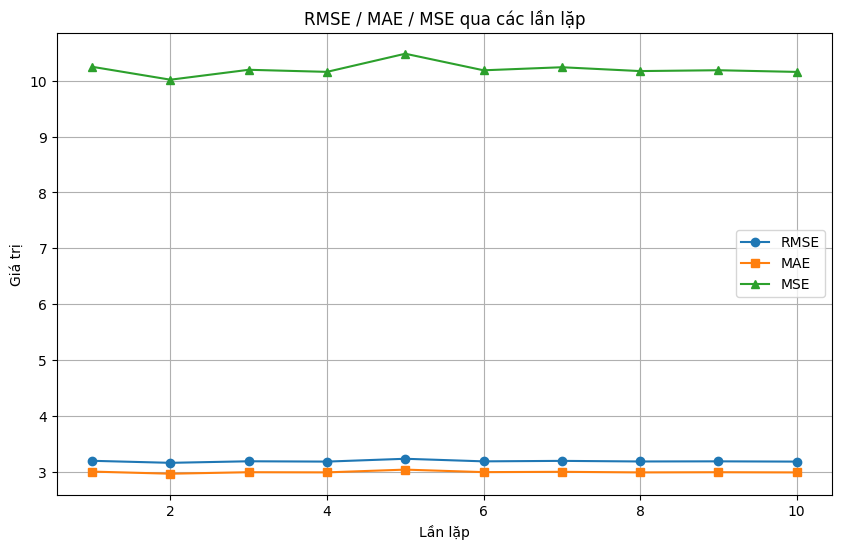

In [8]:
# 8) Plot các metric theo từng lần lặp
iterations = np.arange(1, n_runs + 1)

plt.figure(figsize=(10, 6))
plt.plot(iterations, rmse_list, marker='o', label='RMSE')
plt.plot(iterations, mae_list, marker='s', label='MAE')
plt.plot(iterations, mse_list, marker='^', label='MSE')
plt.xlabel('Lần lặp')
plt.ylabel('Giá trị')
plt.title('RMSE / MAE / MSE qua các lần lặp')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
import pickle

with open('ncf_model.pkl', 'wb') as f:
    pickle.dump(ncf_model, f)

print("Luu mo hinh thanh cong")

TypeError: cannot pickle 'SymbolicTensor' object